# Aligning Audios

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, correlate
import copy


data_source_path = '../data/not_aligned/all'
pivot_file_name = '20231021_190000h.npy'
preprocessed_data_path = '../data/not_aligned/freq_cut'
data_destination_path = '../data/aligned/all'

PREPROCESSING AUDIO DATA

In [2]:
def preprocess_data(data_source_path: str, lowest_frec_cut: int, highest_frec_cut: int, data_destination_path: str = None) -> str:
    """
    Preprocesses audio data by loading .npy files from the specified directory, 
    cutting the frequency range, and saving the processed data to a new directory.
    
    Args:
        data_source_path (str): The path to the directory containing the .npy files.
        lowest_frec_cut (int): The lowest frequency cut-off index.
        highest_frec_cut (int): The highest frequency cut-off index.
    
    Returns:
        str: The path to the directory where the processed files are saved.
    """

    # List all .npy files in the specified directory
    files = [f for f in os.listdir(data_source_path) if f.endswith('.npy')]

    # Define the directory to save the processed files
    if data_destination_path is not None:
        freq_cut = data_destination_path
    else:
        freq_cut = f"{os.path.dirname(os.path.abspath(__file__))}/freq_cut"

    # Create the directory if it doesn't exist
    os.makedirs(freq_cut, exist_ok=True)

    # Process each file
    for file in files:
        # Load the .npy file
        data = np.load(os.path.join(data_source_path, file))

        # Cut the frequency range of the data
        freq_cut_data = data[lowest_frec_cut:highest_frec_cut:]

        # Save the processed data to the new directory
        np.save(os.path.join(freq_cut, file), freq_cut_data)
        
    return freq_cut

In [3]:
saved_files_path = preprocess_data(
        data_source_path=data_source_path, 
        lowest_frec_cut=113, 
        highest_frec_cut=117, 
        data_destination_path=preprocessed_data_path
    )

CALCULATING TEMPORAL ENERGIES

In [4]:
def get_temporal_energies(freq_cut_source_path: str) -> dict:
    """
    Calculate the temporal energies of mel-spectrograms stored in .npy files within a given directory.
    Args:
        freq_cut_source_path (str): The path to the directory containing the .npy files with mel-spectrograms.
    Returns:
        dict: A dictionary where the keys are the filenames of the .npy files and the values are the temporal energies 
              (1D numpy arrays) calculated by summing the intensities along the frequency axis for each mel-spectrogram.
    """

    # Get the list of .npy files in the directory
    files = [f for f in os.listdir(freq_cut_source_path) if f.endswith('.npy')]
    
    temporal_energy_per_audio = {}

    for _, file in enumerate(files):
        # Load the mel-spectrogram matrix
        mel_spectrogram = np.load(os.path.join(freq_cut_source_path, file))
        
        # Calculate the temporal energy by summing the intensities along the frequency axis
        temporal_energy = np.sum(mel_spectrogram, axis=0)
        
        temporal_energy_per_audio[file] = temporal_energy

    return temporal_energy_per_audio

In [5]:
temporal_energy_per_audio = get_temporal_energies(
        freq_cut_source_path=saved_files_path
    )

PLOTTING TEMPORAL ENERGIES

In [6]:
def plot_energies(temporal_energy_per_audio: dict) -> None:
    """
    Plots the temporal energy of multiple audio files.
    
    Parameters:
    temporal_energy_per_audio (dict): A dictionary where the keys are filenames (str) and the values are lists 
    or arrays representing the temporal energy of the corresponding audio file.
    
    Returns:
    None
    """
  
    # Colors for the plots
    colors = plt.cm.viridis(np.linspace(0, 1, len(temporal_energy_per_audio.keys())))
    
    for i, (file, temporal_energy) in enumerate(temporal_energy_per_audio.items()):
        
        # Create a figure for each file
        plt.figure(figsize=(12, 6))
        
        # Plot the temporal energy
        plt.plot(temporal_energy, color=colors[i], label=file)
        
        # Configure the plot
        plt.xlabel('Time Index')
        plt.ylabel('Energy')
        plt.title(f'Temporal Energy for {file}')
        plt.legend(loc='upper right')
        plt.tight_layout()
        plt.show() 

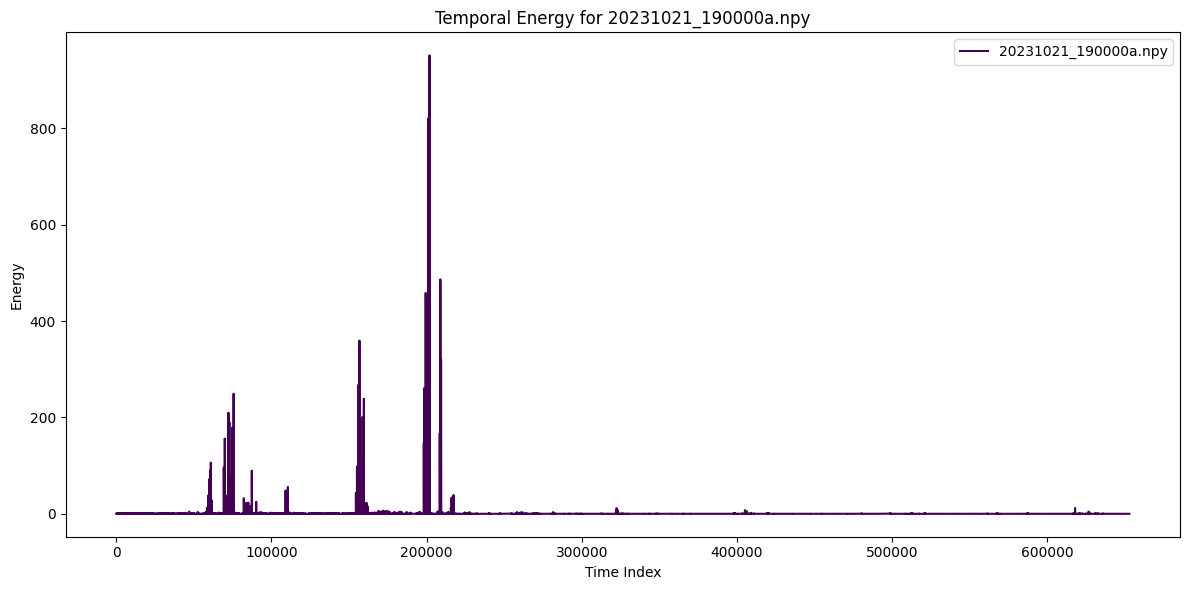

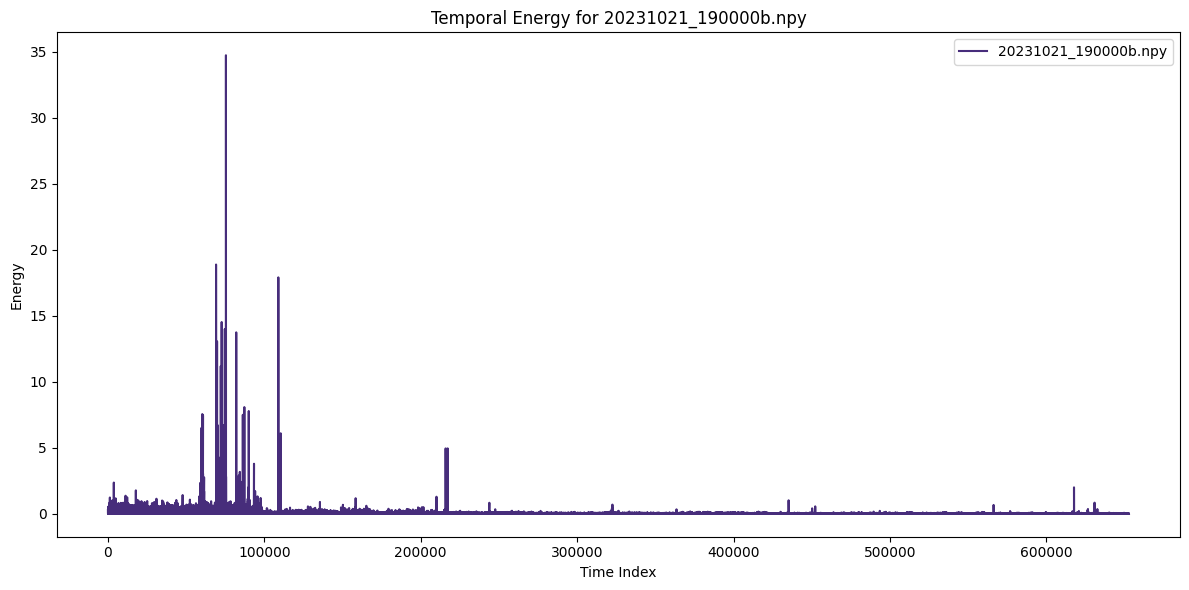

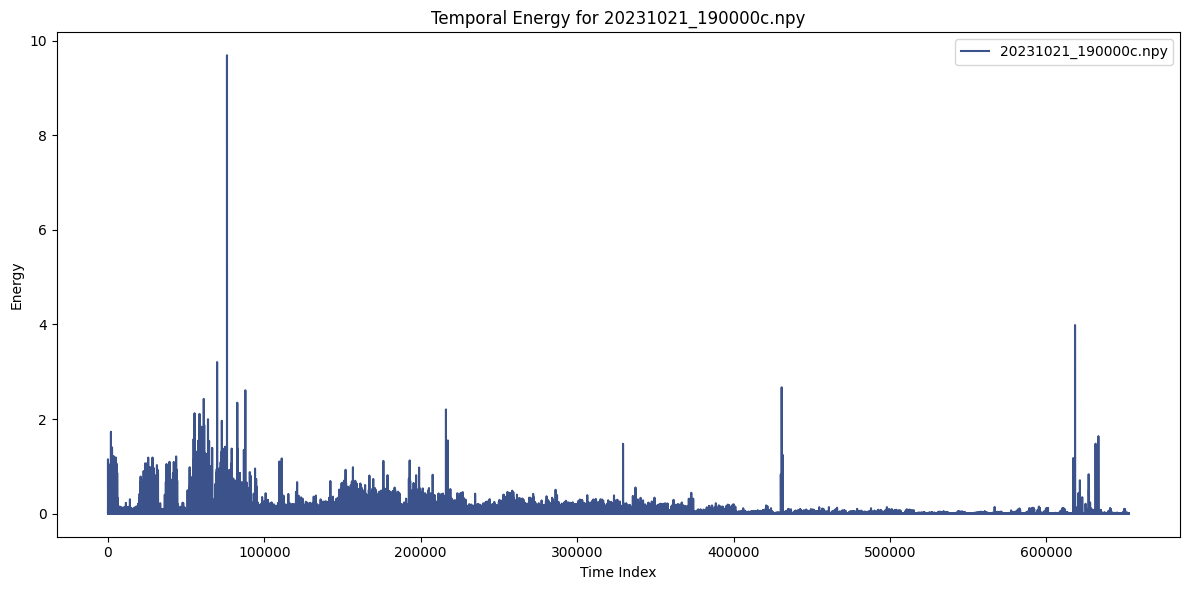

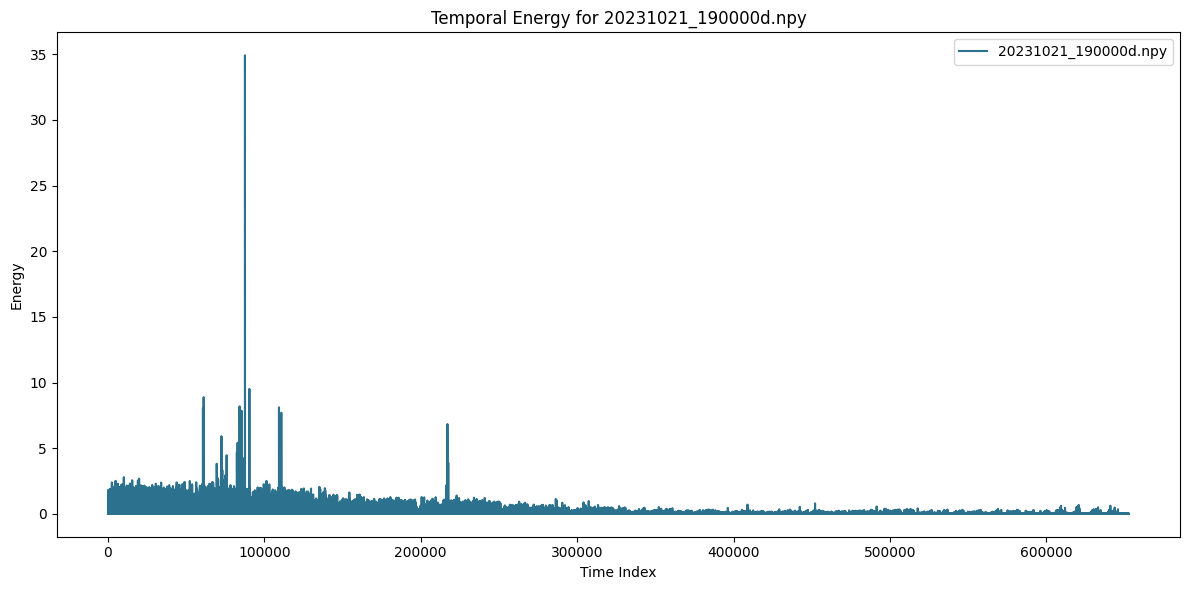

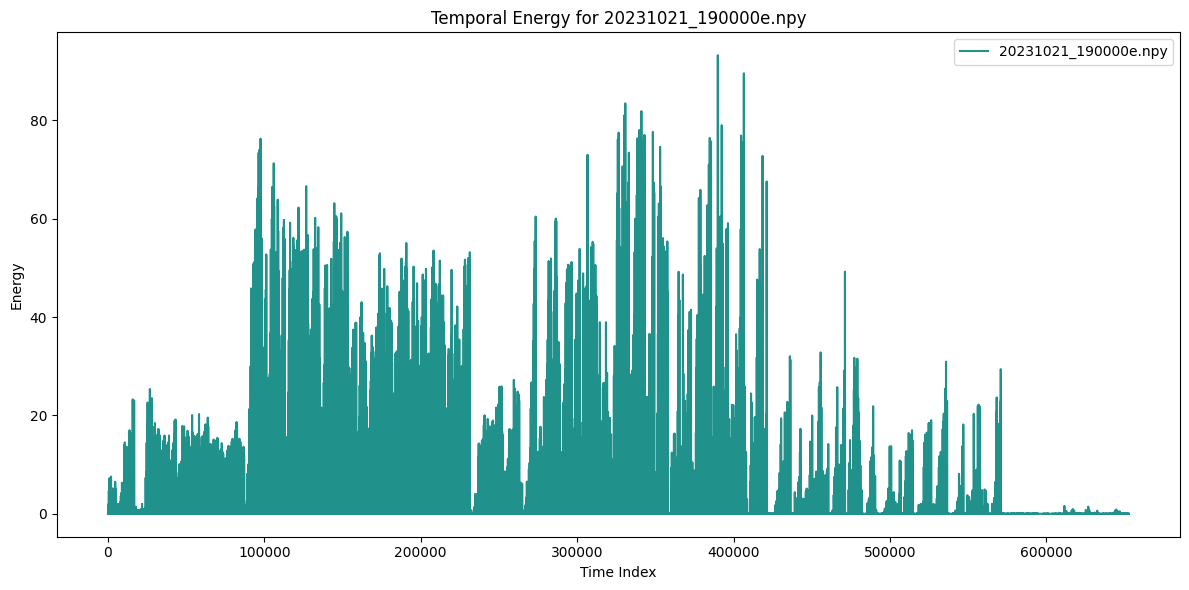

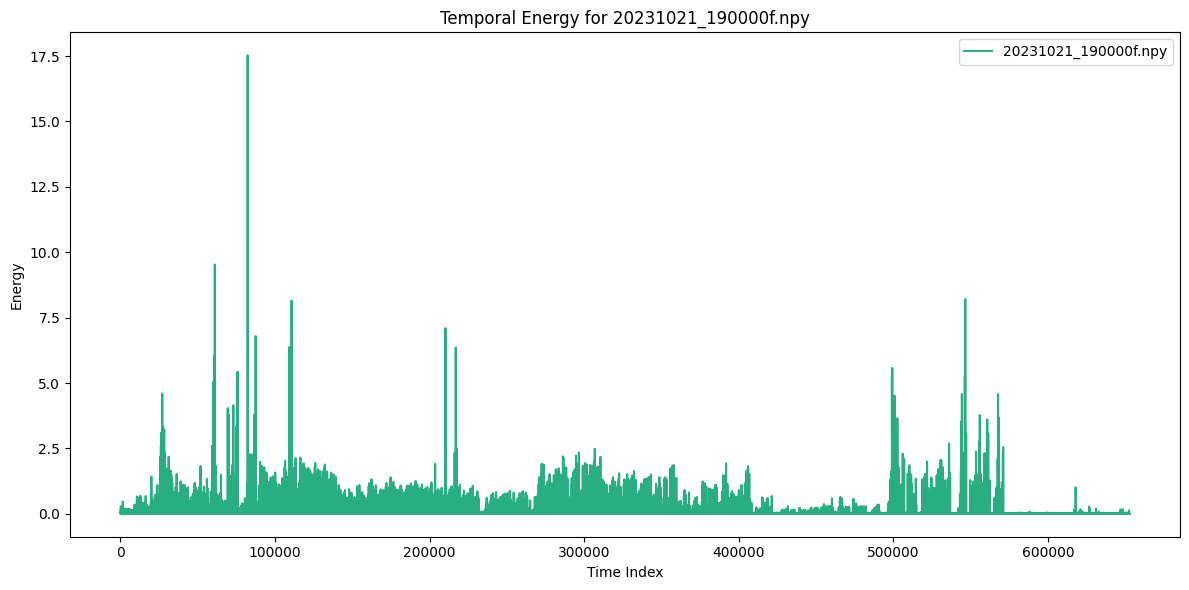

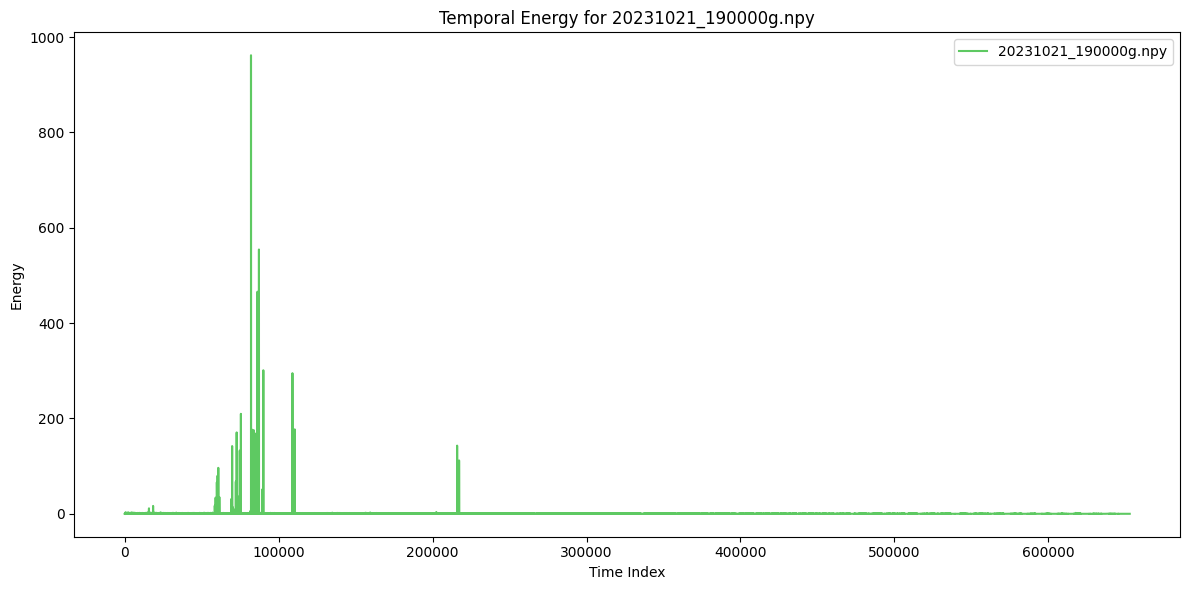

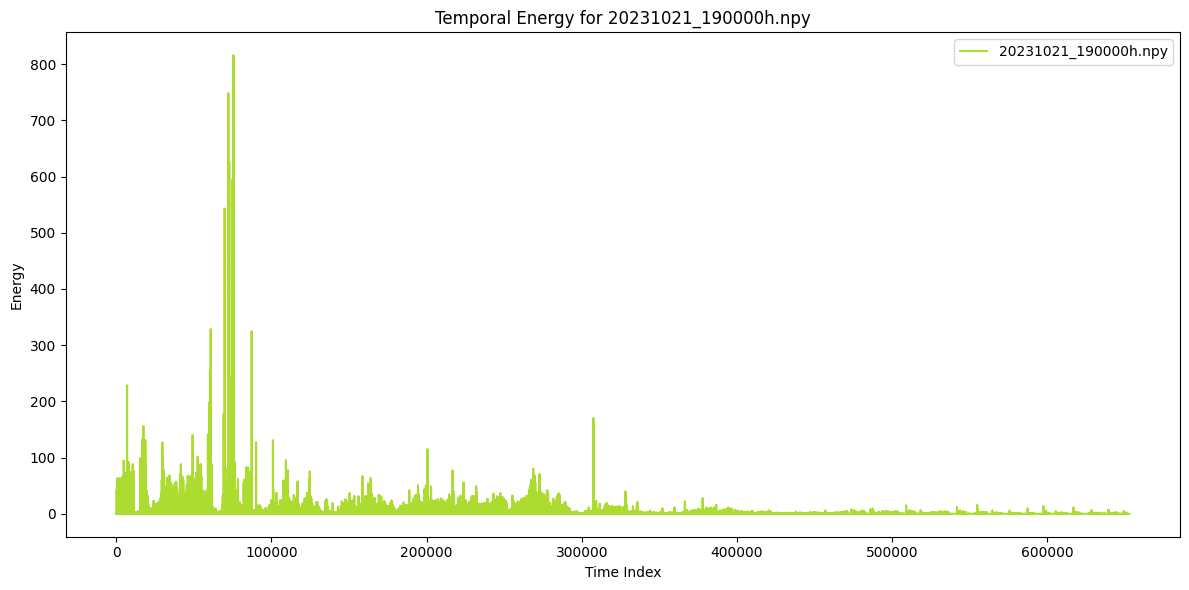

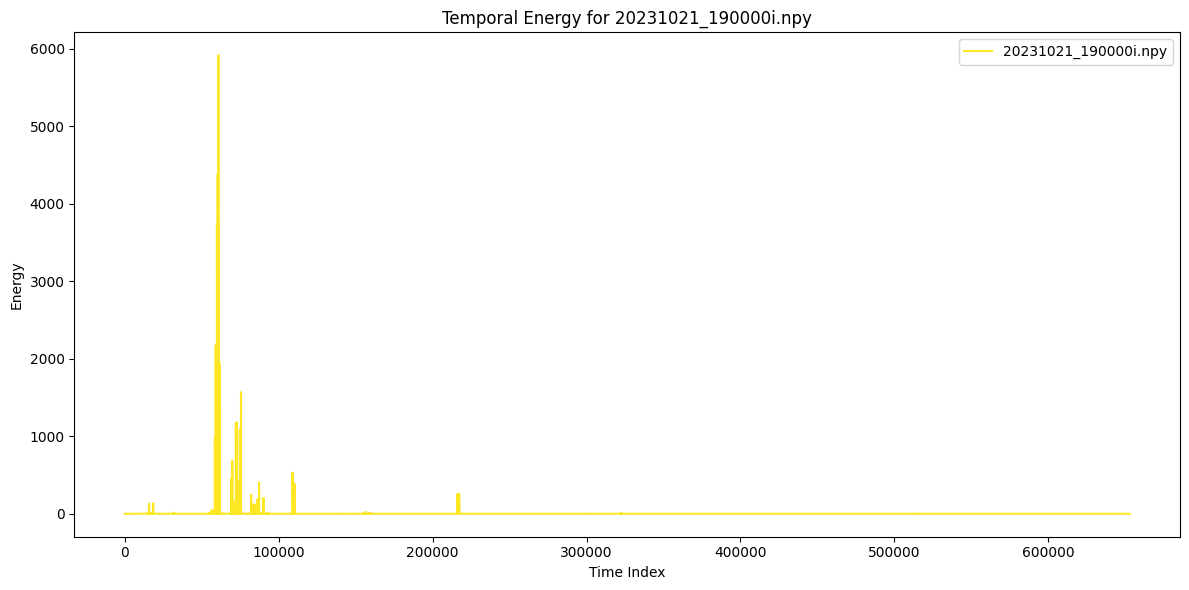

In [7]:
plot_energies(temporal_energy_per_audio=temporal_energy_per_audio)

FILTERING ENERGIES

In [8]:
def plot_energies_histogram_and_get_bin_width(temporal_energies: dict) -> dict:
    """
    Plots histograms of temporal energies and returns a dictionary with bin widths.

    Parameters:
    -----------
    temporal_energies : dict
        A dictionary where keys are filenames and values are lists of temporal energies.

    Returns:
    --------
    dict
        A dictionary where keys are filenames and values are the bin widths.
    """
    
    # Create a figure with 9 subplots and a size of 16x16 inches
    fig, axs = plt.subplots(3, 3, figsize=(16, 16))

    # Flatten the array of axes to iterate over it
    axs = axs.flatten()

    limits = {}

    count = 1
    # Iterate over the files and axes at the same time
    for file, ax in zip(temporal_energies, axs):
        # Calculate the bin width
        bin_width = (max(temporal_energies[file]) - min(temporal_energies[file])) / 50
        limits[file] = bin_width
        print(f'Bin width for {count}: {bin_width}')

        # Create a histogram of the energies for this file
        ax.hist(temporal_energies[file], bins=50)

        # Configure the plot
        ax.set(xlabel='Index', ylabel='Frequency', title=f'Energy histogram for {count}')
        ax.set_yscale('log')
        count += 1

    # Show the plot
    plt.tight_layout()
    plt.show()

    # Return the dictionary with bin widths
    return limits

Bin width for 1: 19.031175537109377
Bin width for 2: 0.6949266052246094
Bin width for 3: 0.19376754760742188
Bin width for 4: 0.6985127258300782
Bin width for 5: 1.864009246826172
Bin width for 6: 0.3506366729736328
Bin width for 7: 19.23427490234375
Bin width for 8: 16.31604736328125
Bin width for 9: 118.34861328125


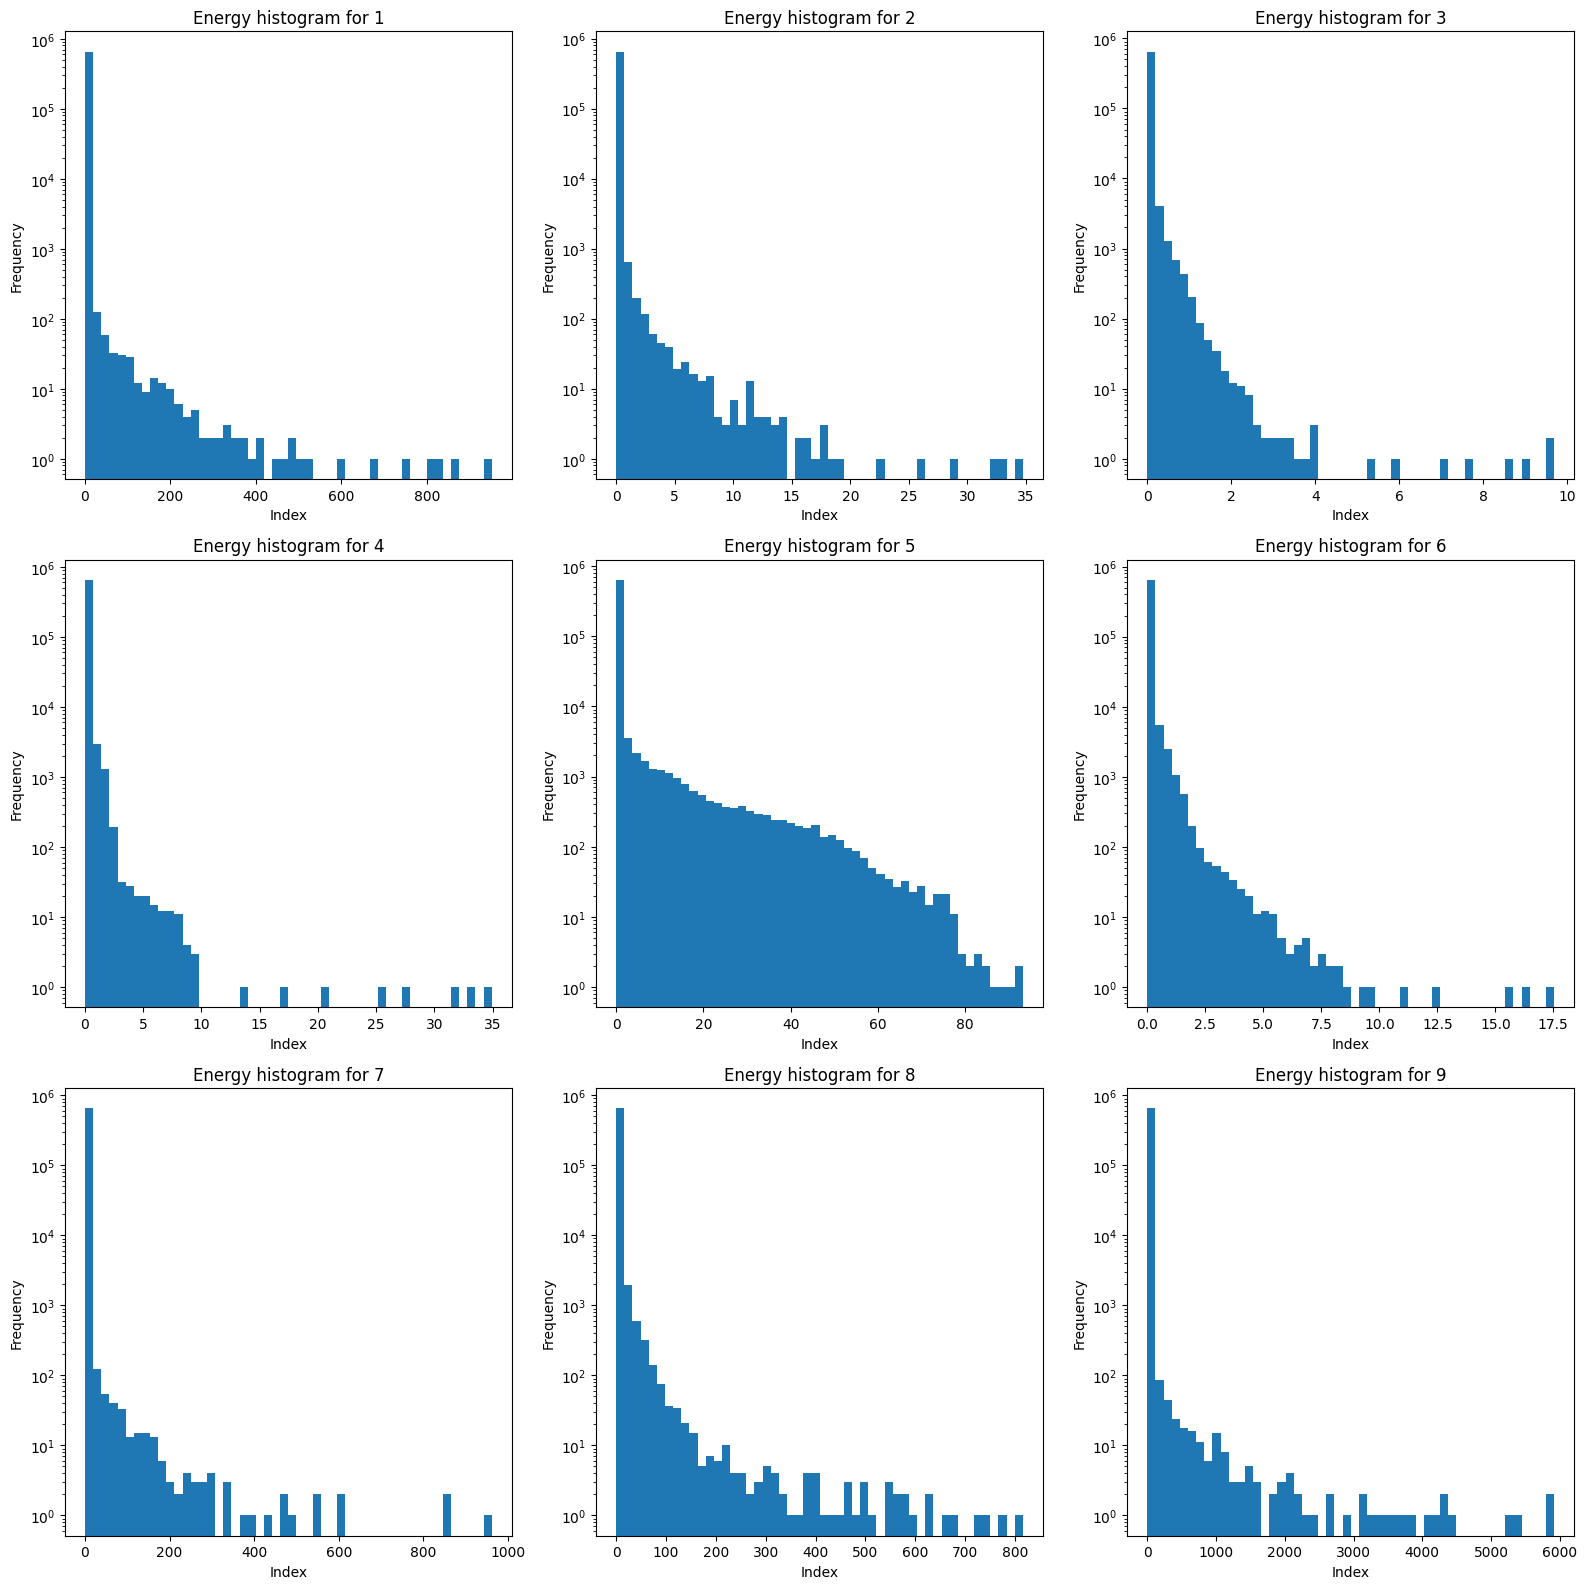

In [9]:
energy_limits = plot_energies_histogram_and_get_bin_width(temporal_energies=temporal_energy_per_audio)

In [10]:
def filter_temporal_energies(temporal_energy_per_audio: dict, energy_limits: dict) -> dict:
    """
    Filtra las energías temporales en el diccionario temporal_energy_per_audio según los límites en energy_limits.
    
    Args:
        temporal_energy_per_audio (dict): Diccionario donde las claves son nombres de archivos y los valores son arrays de energías temporales.
        energy_limits (dict): Diccionario donde las claves son nombres de archivos y los valores son los límites de energía.
    
    Returns:
        dict: Diccionario con las energías temporales filtradas.
    """
    filtered_temporal_energy_per_audio = {}
    
    for file, energy_array in temporal_energy_per_audio.items():
        limit = energy_limits.get(file, None)
        if limit is not None:
            filtered_energy_array = np.where(energy_array < limit, 0, energy_array)
            filtered_temporal_energy_per_audio[file] = filtered_energy_array
    
    return filtered_temporal_energy_per_audio



In [ ]:
temporal_energy_per_audio = filter_temporal_energies(
    temporal_energy_per_audio=temporal_energy_per_audio, 
    energy_limits=energy_limits)


IDENTIFYING ENERGY PEAKS

In [11]:
def get_energy_peaks(temporal_energy_per_audio : dict) -> dict:
    """
    Identify and filter energy peaks in audio signals.
    This function processes a dictionary of temporal energy arrays for multiple audio files,
    identifies the peaks in each array using a specified window, and filters out peaks with
    energy values less than or equal to 1.
    Parameters:
    temporal_energy_per_audio (dict): A dictionary where keys are filenames and values are
                                        lists or arrays representing the temporal energy of the audio.
    Returns:
    dict: A dictionary where keys are filenames and values are lists of indices representing
            the filtered peak points in the temporal energy arrays.
    """


    energy_peaks_per_audio = {}
    
    # Process the energy arrays to find the peak points
    for _, (file, temporal_energy) in enumerate(temporal_energy_per_audio.items()):
        # Find the energy peaks with a window of 4 indices to the left and right
        peaks, _ = find_peaks(temporal_energy, distance=8)
        
        # Filter the peaks that have energy greater than 1
        filtered_peaks = [peak for peak in peaks if temporal_energy[peak] > 1]
            
        energy_peaks_per_audio[file] = filtered_peaks

    return energy_peaks_per_audio

In [12]:
energy_peaks_per_audio = get_energy_peaks(
        temporal_energy_per_audio=temporal_energy_per_audio
    )

PLOTTING ENERGY PEAKS

In [13]:
def plot_energy_peaks(energy_peaks_per_audio : dict, temporal_energy_per_audio : dict, xlim_left : int = -1, xlim_right : int = -1) -> None:
    """
    Plots the energy peaks for multiple audio files.
    
    Parameters:
    -----------
    energy_peaks_per_audio : dict
        A dictionary where keys are filenames and values are lists of indices representing the peaks in the energy signal.
    temporal_energy_per_audio : dict
        A dictionary where keys are filenames and values are arrays representing the temporal energy of the audio signal.
    xlim_left : int
        The left limit for the x-axis of the plot.
    xlim_right : int
        The right limit for the x-axis of the plot.
   
    Returns:
    --------
    None
        This function does not return any value. It displays the plots of energy peaks for the given audio files.
    """

    # Specific colors for the plots
    colors = plt.cm.viridis(np.linspace(0, 1, len(energy_peaks_per_audio.keys())))

    # Process the energy arrays to get the maximum points of the peaks
    for i, (file, peaks) in enumerate(energy_peaks_per_audio.items()):
        
        plt.figure(figsize=(12, 6))
        
        # Plot only the maximum points of the peaks and their 4 immediate points to the left and right
        for peak in peaks:
            # Get the indices of the points to plot
            indexes = range(max(0, peak-4), min(len(temporal_energy_per_audio[file]), peak+5))
            plt.plot(indexes, temporal_energy_per_audio[file][indexes], color=colors[i % len(colors)])
        
        # Configure the plot
        plt.xlabel('Time Index')
        plt.ylabel('Energy')
        plt.title(f'Temporal Energy Peaks for {file}')
        plt.tight_layout()
        if xlim_left != -1 and xlim_right != -1:
            plt.xlim(xlim_left, xlim_right)
        elif xlim_left != -1:
            plt.xlim(xlim_left,)
        elif xlim_right != -1:
            plt.xlim(xlim_right)
        plt.show()

    

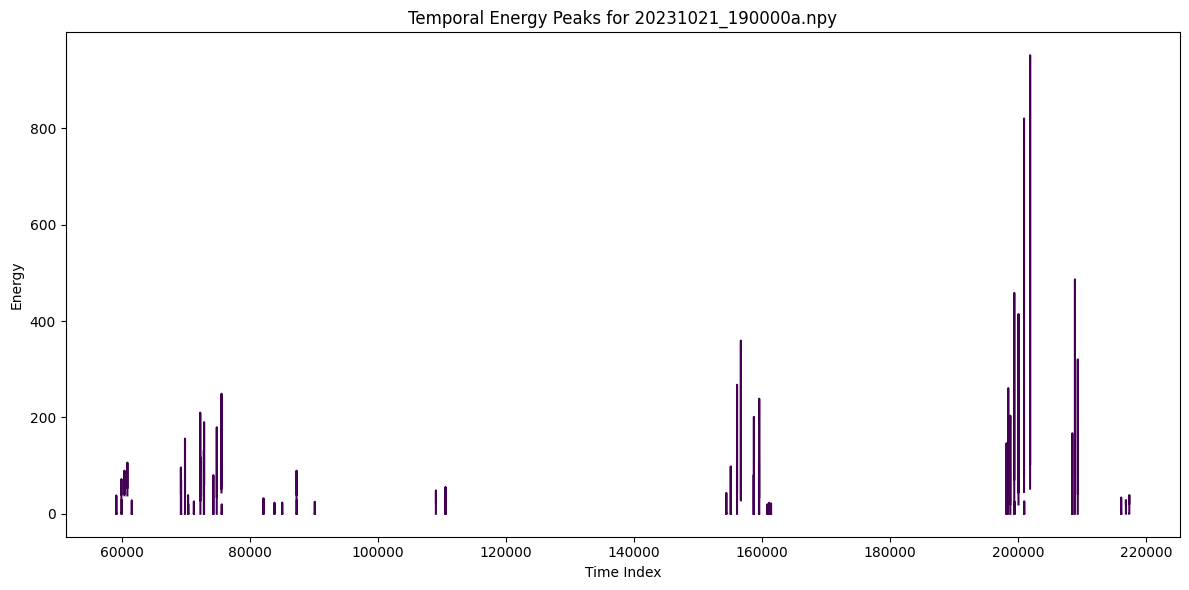

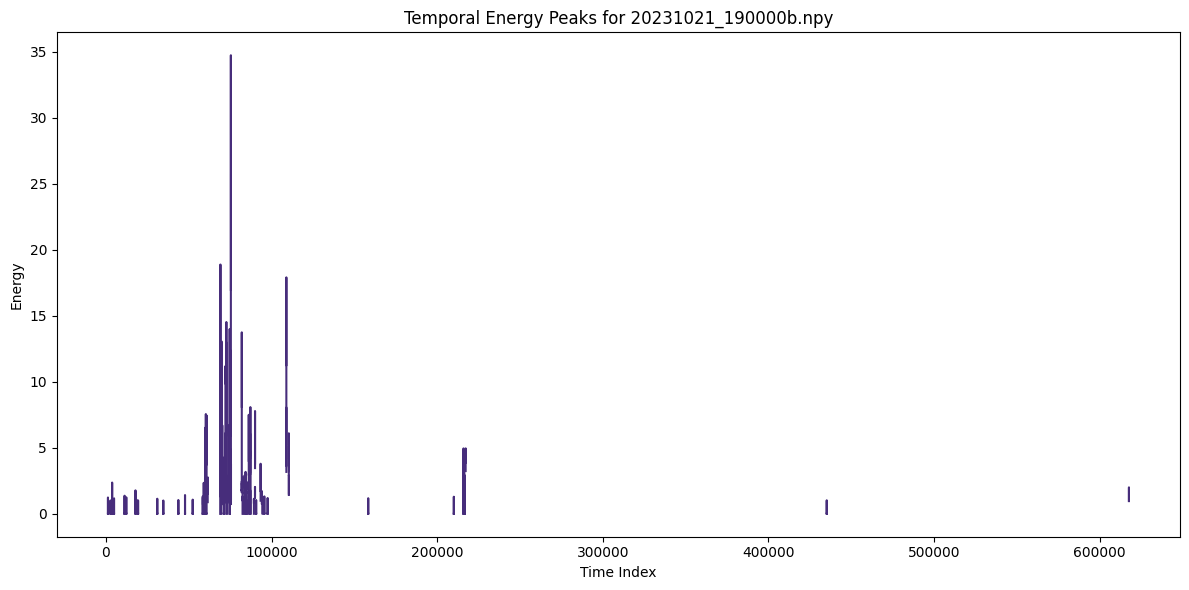

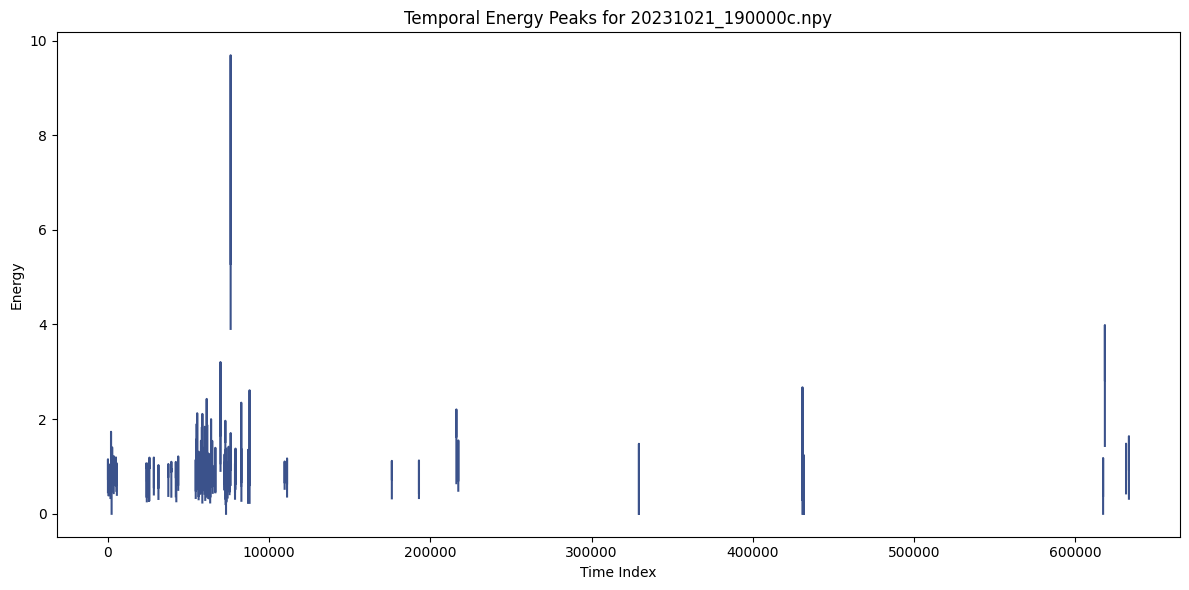

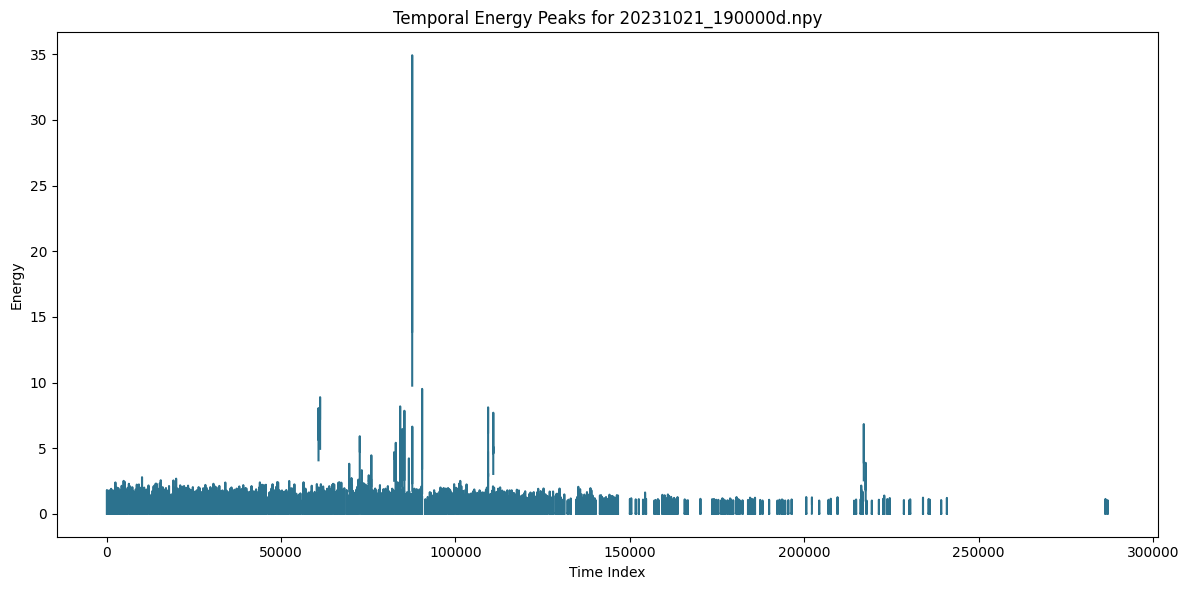

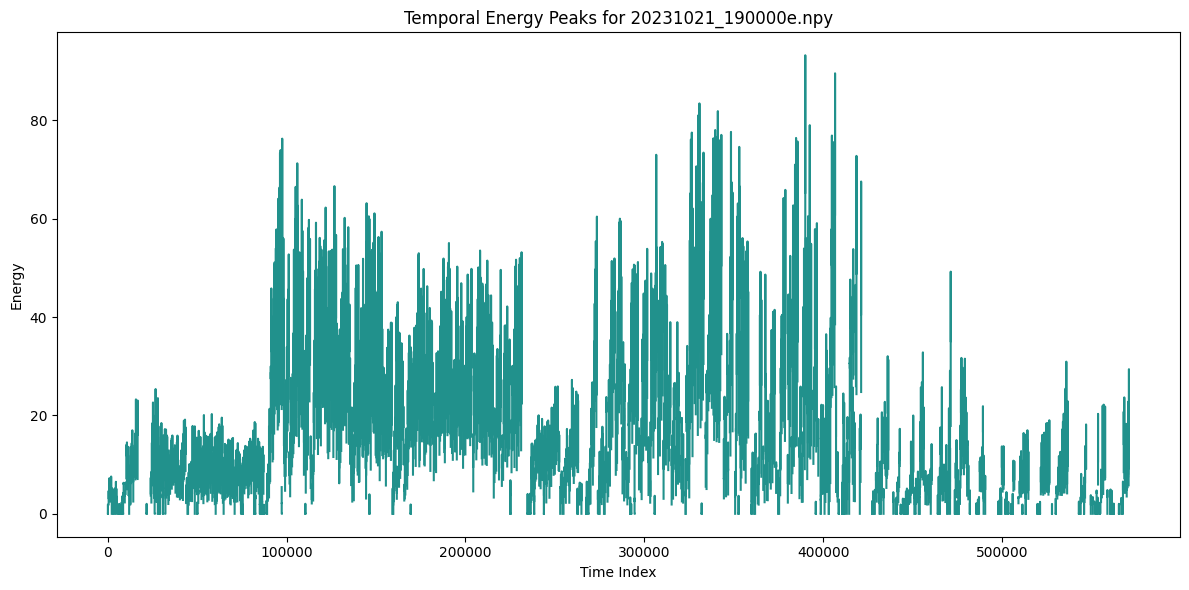

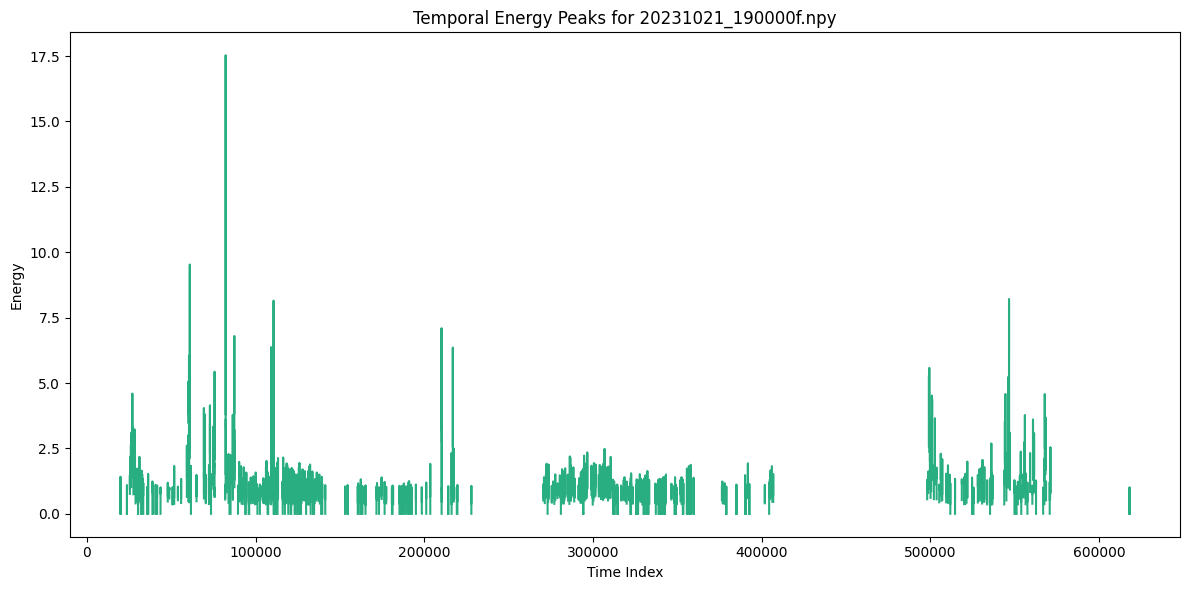

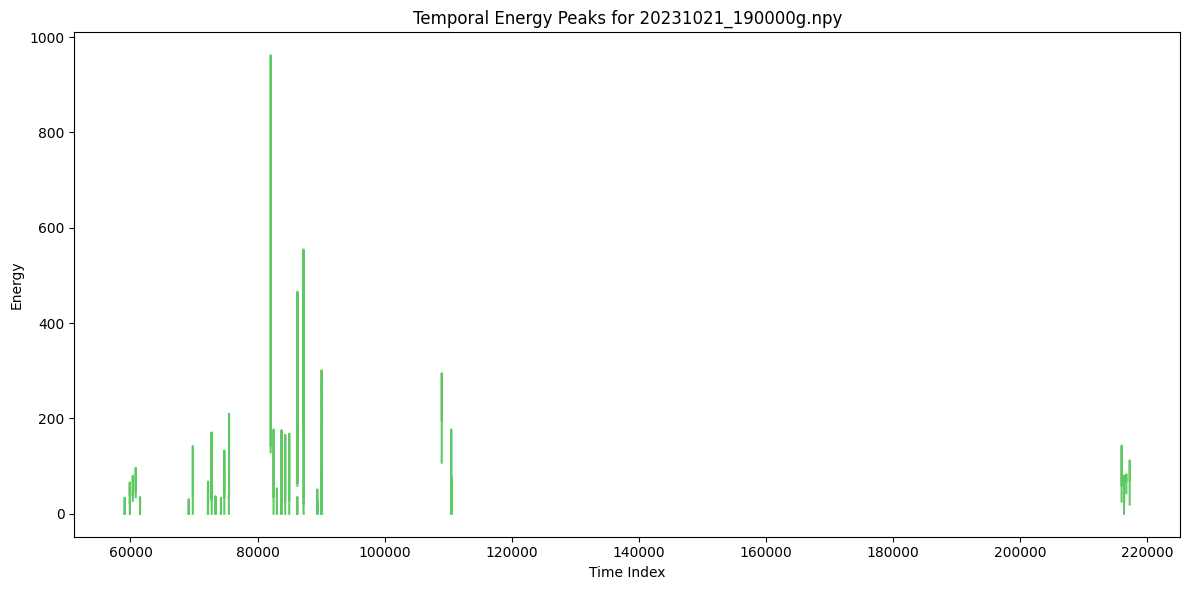

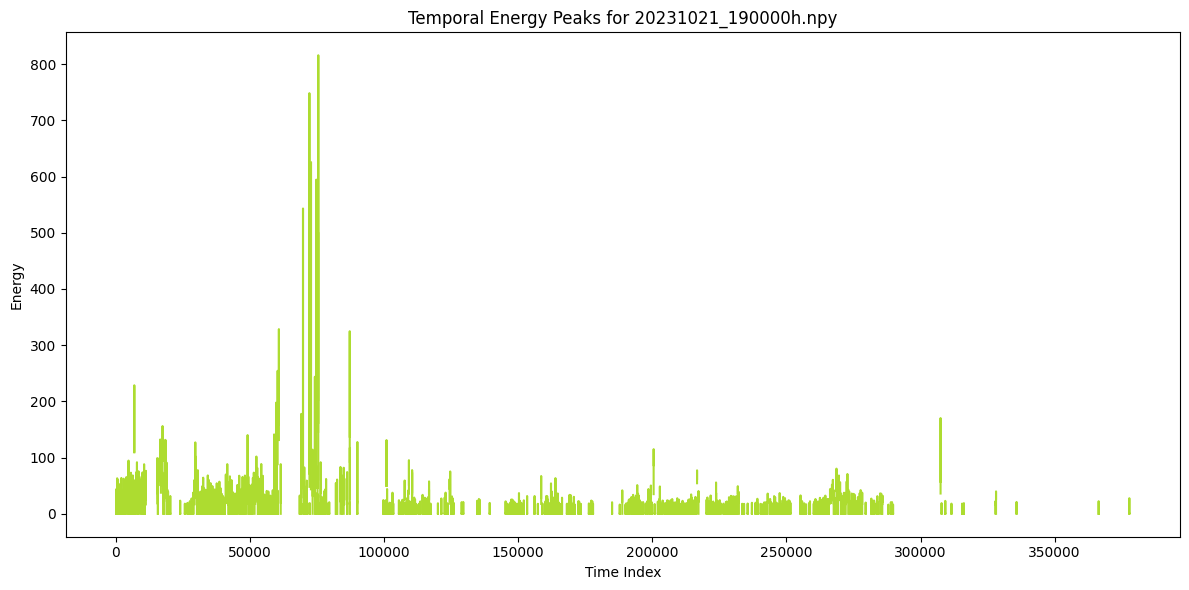

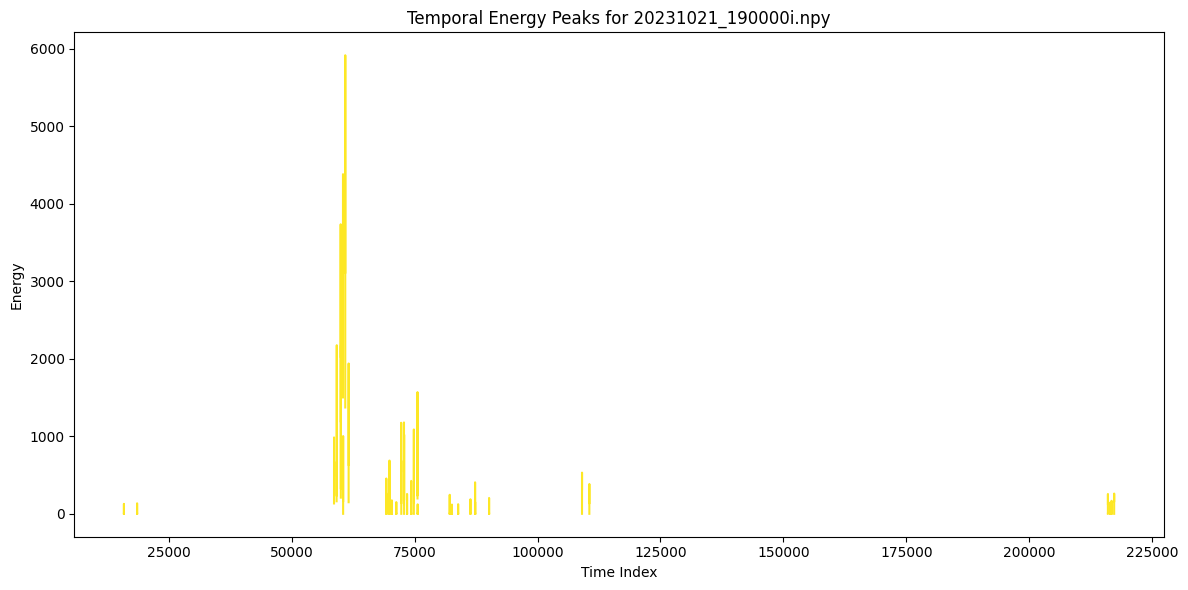

In [14]:
plot_energy_peaks(
            energy_peaks_per_audio=energy_peaks_per_audio,
            temporal_energy_per_audio=temporal_energy_per_audio,
            # xlim_left=5000,
            # xlim_right=15000,
        )

PLOTTING ENERGY PEAKS ON A LOGATITHMIC SCALE

In [15]:
def plot_energy_peaks_log(energy_peaks_per_audio : dict, temporal_energy_per_audio : dict, xlim_left : int = -1, xlim_right : int = -1) -> None:
    """
    Plots the energy peaks of audio signals on a logarithmic scale.
    This function takes in dictionaries containing energy peaks and temporal energy values for multiple audio files,
    and plots the energy peaks on a logarithmic scale. Each audio file's peaks are plotted with a unique color.
    
    Parameters:
    -----------
    energy_peaks_per_audio : dict
        A dictionary where keys are filenames and values are lists of peak indices for the corresponding audio file.
    temporal_energy_per_audio : dict
        A dictionary where keys are filenames and values are arrays of temporal energy values for the corresponding audio file.
    xlim_left : int
        The left limit for the x-axis of the plot.
    xlim_right : int
        The right limit for the x-axis of the plot.
    
    Returns:
    --------
    None
    """

    # Specific colors for the plots
    colors = plt.cm.viridis(np.linspace(0, 1, len(energy_peaks_per_audio.keys())))

    # Process the energy arrays to get the maximum points of the peaks
    for i, (file, peaks) in enumerate(energy_peaks_per_audio.items()):
        
        plt.figure(figsize=(12, 6))
        
        # Plot only the maximum points of the peaks and their 4 immediate points to the left and right
        for peak in peaks:
            # Get the indices of the points to plot
            indexes = range(max(0, peak-4), min(len(temporal_energy_per_audio[file]), peak+5))
            # Plot on a logarithmic scale
            plt.plot(indexes, np.log10(temporal_energy_per_audio[file][indexes]), color=colors[i % len(colors)])            
        
        # Configure the plot
        plt.xlabel('Time Index')
        plt.ylabel('Energy (logarithmic scale)')
        plt.title(f'Temporal Energy Peaks for {file}')
        plt.tight_layout()
        if xlim_left != -1 and xlim_right != -1:
            plt.xlim(xlim_left, xlim_right)
        elif xlim_left != -1:
            plt.xlim(xlim_left,)
        elif xlim_right != -1:
            plt.xlim(xlim_right)
        plt.show()


/tmp/ipykernel_104876/2630341397.py:36: RuntimeWarning: divide by zero encountered in log10
  plt.plot(indexes, np.log10(temporal_energy_per_audio[file][indexes]), color=colors[i % len(colors)])


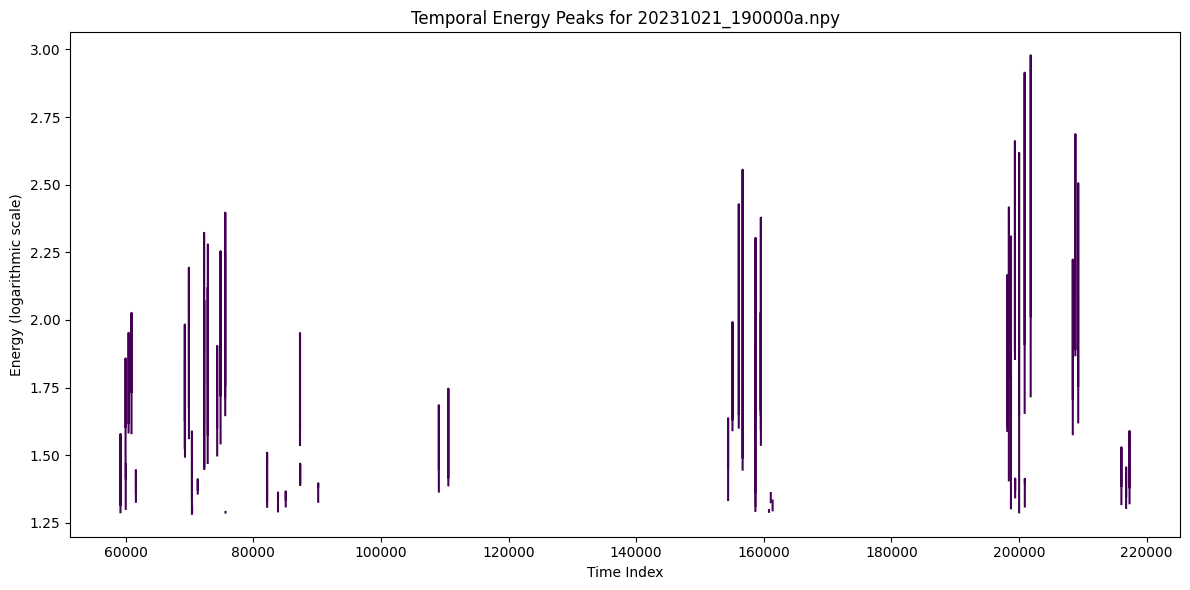

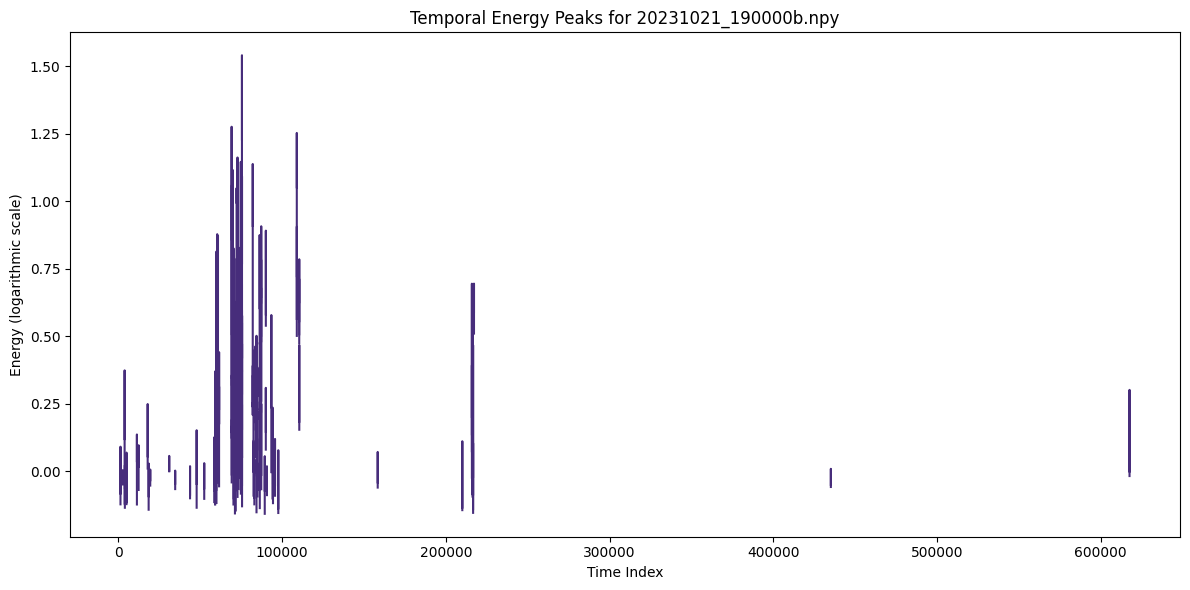

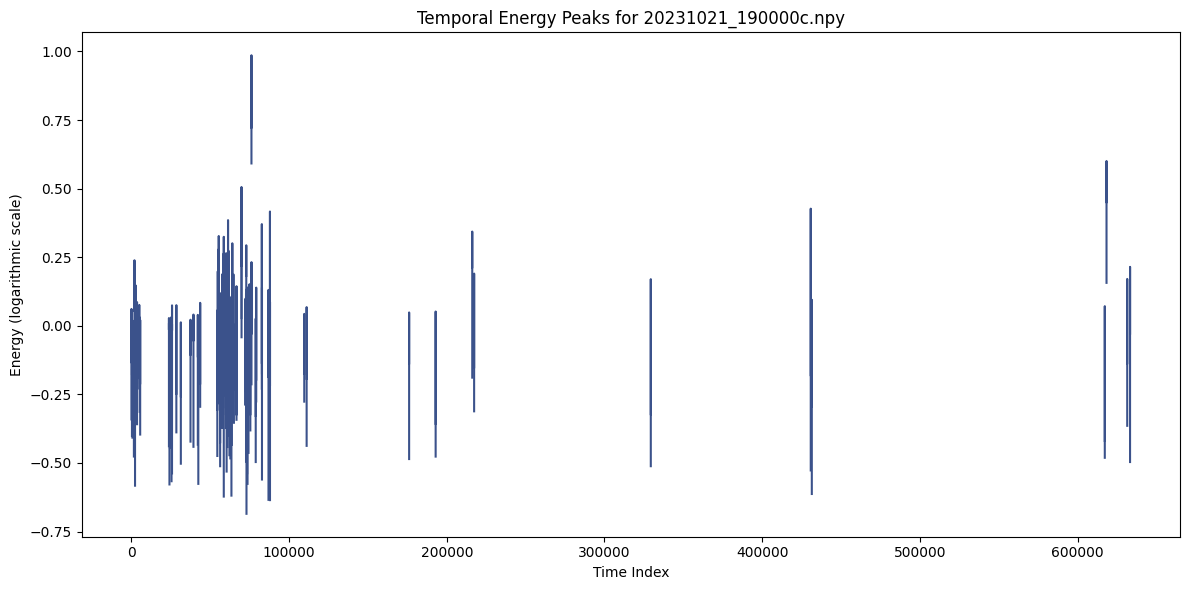

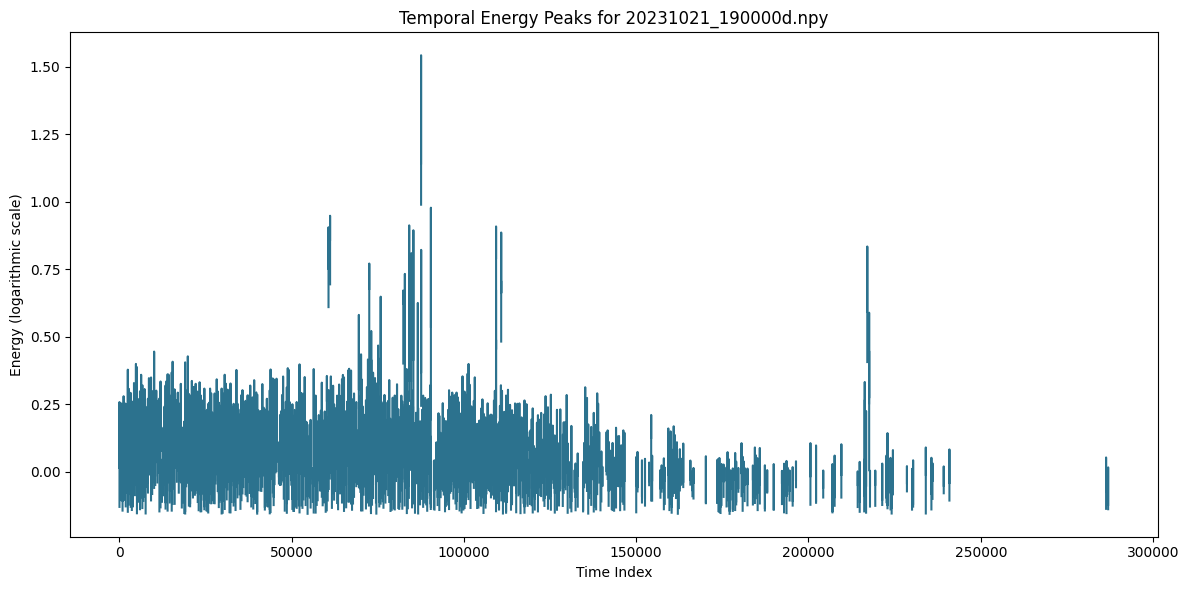

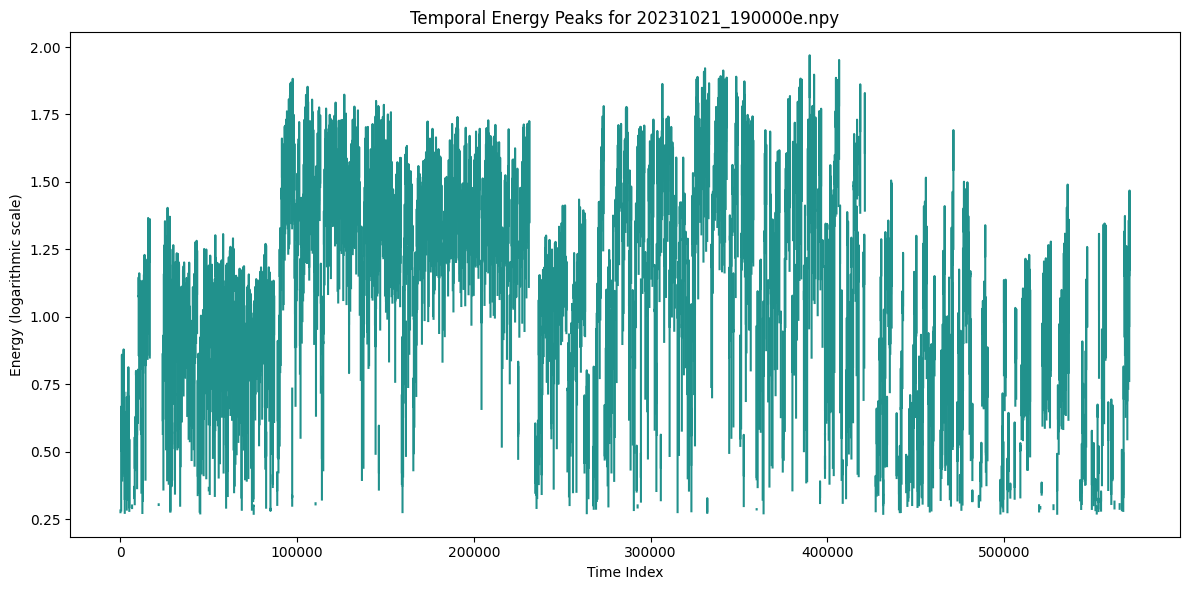

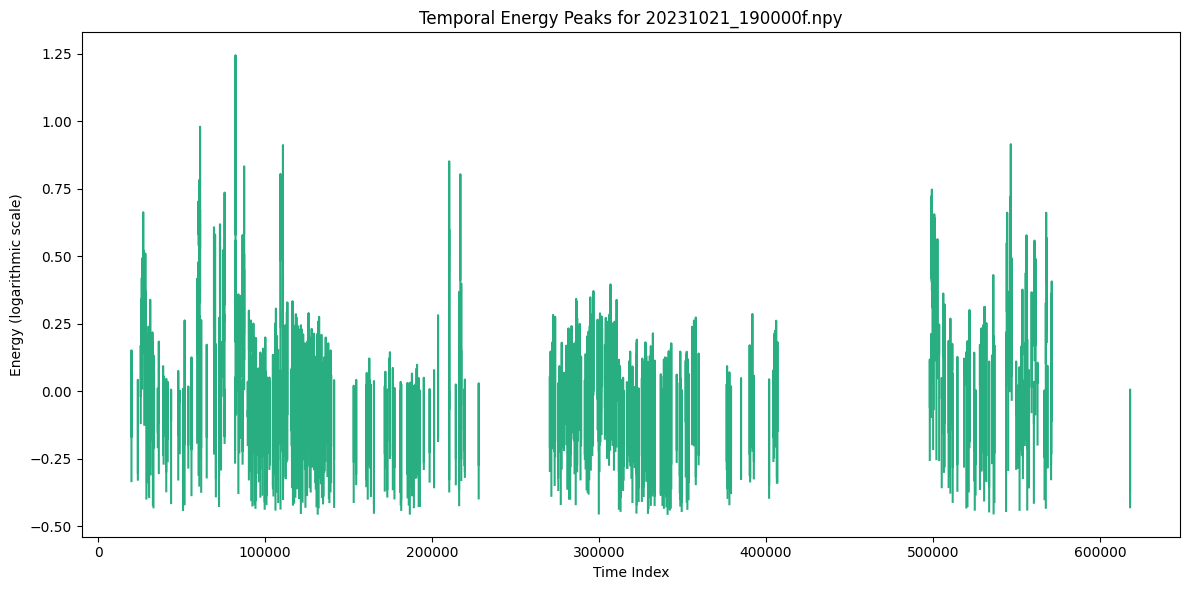

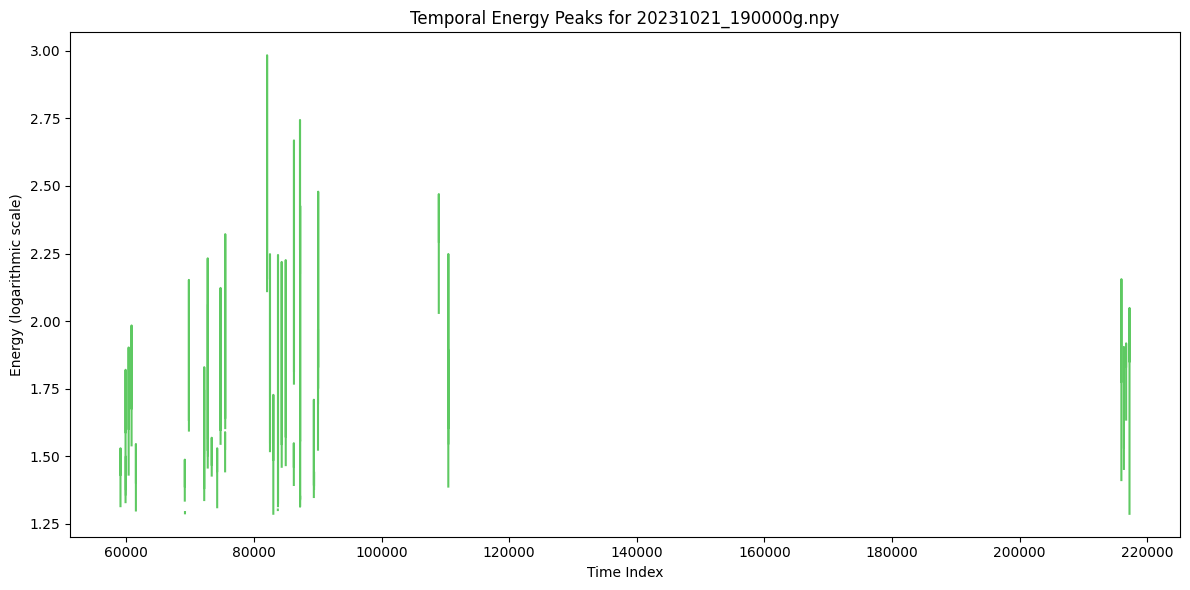

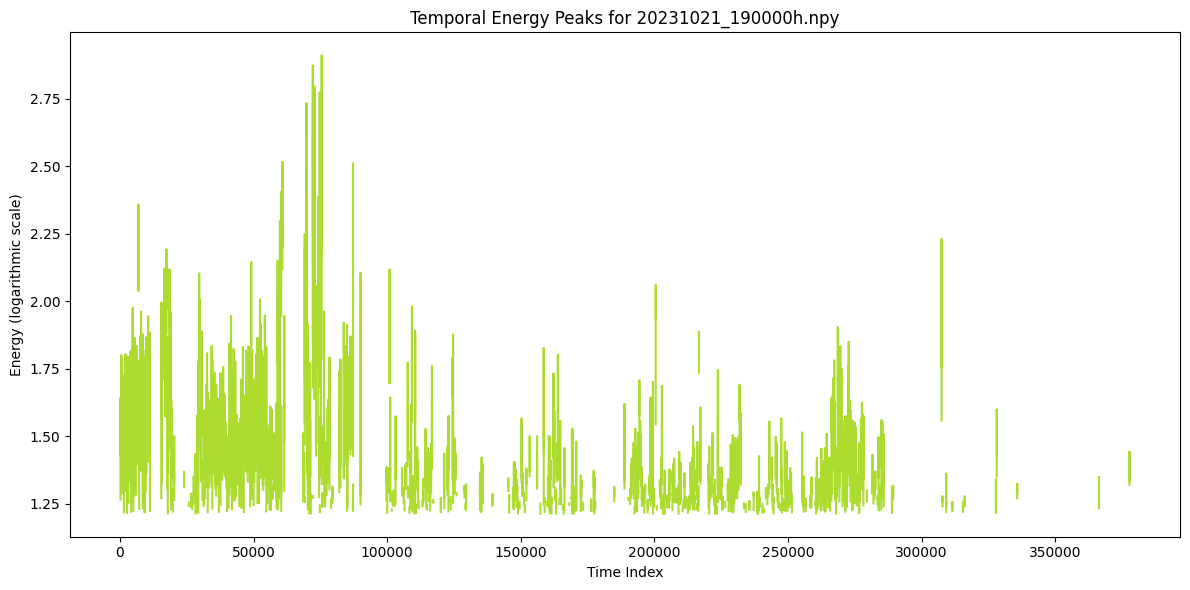

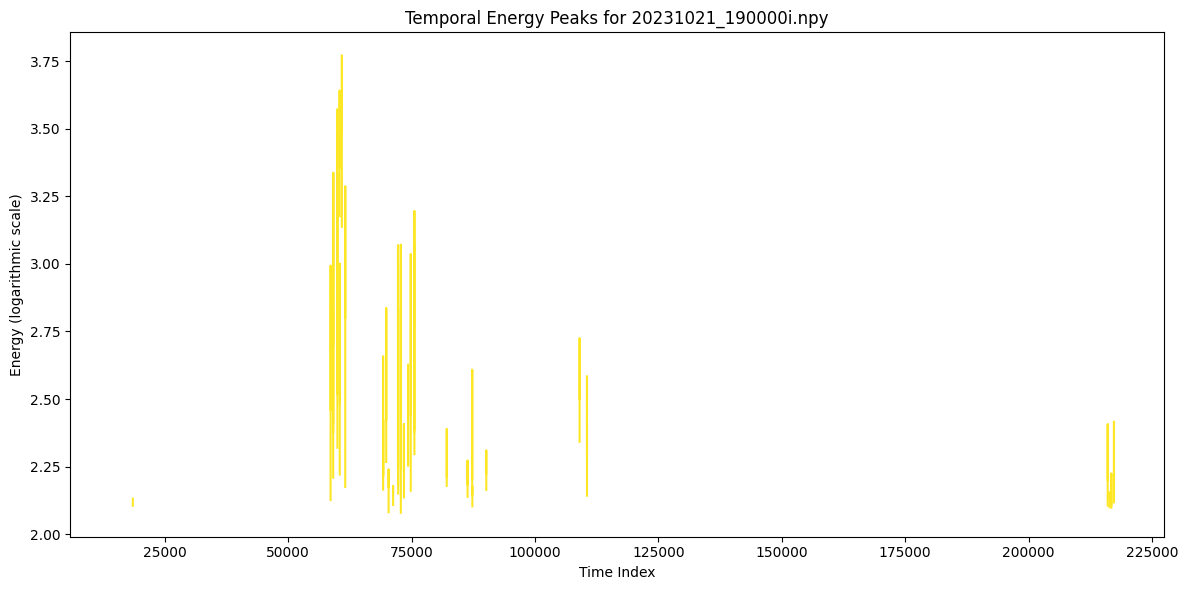

In [16]:
plot_energy_peaks_log(
            energy_peaks_per_audio=energy_peaks_per_audio,
            temporal_energy_per_audio=temporal_energy_per_audio,
            # xlim_left=5000,
            # xlim_right=15000,
        )

PLOTTING ENERGY PEAKS MOMENTS

In [17]:
def plot_energy_peaks_momments(energy_peaks_per_audio: dict, pivot_file_name: str, xlim_left: int = -1, xlim_right: int = -1) -> None:
    """
    Plots the energy peaks moments for multiple audio files.
    Parameters:
    -----------
    energy_peaks_per_audio : dict
        A dictionary where keys are filenames and values are lists of energy peak moments.
    xlim_left : int
        The left limit for the x-axis.
    xlim_right : int
        The right limit for the x-axis.
    Returns:
    --------
    None
        This function does not return any value. It displays a plot.
    """
    
    # Specific colors for the plots
    colors = plt.cm.viridis(np.linspace(0, 1, len(energy_peaks_per_audio.keys())))

    # Create a figure for the plot
    plt.figure(figsize=(12, 6))

    # Process the energy arrays to find the peaks and plot vertical lines
    for i, (file, peaks) in enumerate(energy_peaks_per_audio.items()):
        
        # Variable de control para la etiqueta
        label_set = False
        
        # Plot vertical lines at the moments of energy peaks
        for peak in peaks:
            if file == pivot_file_name:  
                plt.axvline(x=peak, color='black', linestyle='-', label=f'{file}' if not label_set else "")
            else:  # For other files, use a dashed line and the corresponding color
                plt.axvline(x=peak, color=colors[i % len(colors)], linestyle='--', label=f'{file}' if not label_set else "")
            
            # Establecer la variable de control a True después de la primera iteración
            label_set = True

    # Configure the plot
    plt.xlabel('Time Index')
    plt.ylabel('Energy')
    plt.title('Energy Peaks Moments')
    plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
    plt.tight_layout()
    if xlim_left != -1 and xlim_right != -1:
        plt.xlim(xlim_left, xlim_right)
    elif xlim_left != -1:
        plt.xlim(xlim_left,)
    elif xlim_right != -1:
        plt.xlim(xlim_right)
    plt.show()

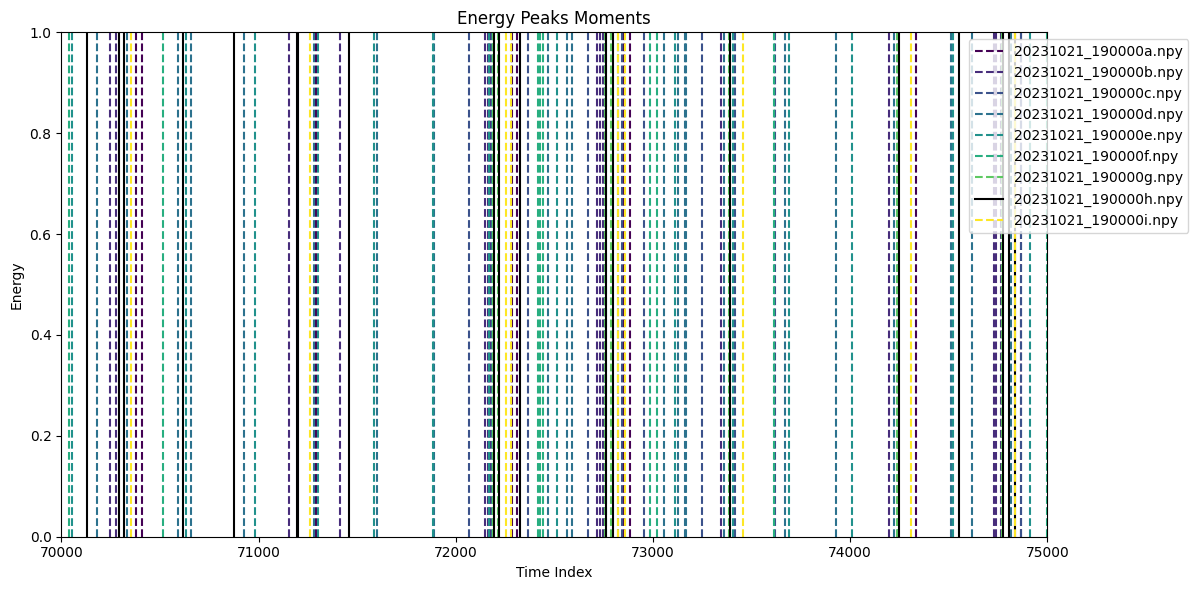

In [18]:
plot_energy_peaks_momments(
            energy_peaks_per_audio=energy_peaks_per_audio,
            pivot_file_name=pivot_file_name,
            xlim_left=70000,
            xlim_right=75000,
        )

CALCULATING LAGS FOR ALIGNMENT

In [19]:
def get_lags(energy_peaks_per_audio : dict, temporal_energy_per_audio : dict, pivot_audio : str) -> dict:
    """
    Calculate the lags that maximize the cross-correlation of energy peaks between a pivot audio file and other audio files.
    
    Args:
        energy_peaks_per_audio (dict): A dictionary where keys are filenames and values are lists of indices representing energy peaks.
        temporal_energy_per_audio (dict): A dictionary where keys are filenames and values are arrays representing temporal energy.
        pivot_audio (str): The filename of the pivot audio file to which other files will be aligned.
    
    Returns:
        dict: A dictionary where keys are filenames and values are the lags (in samples) that maximize the cross-correlation with the pivot audio file.
    """
   
    # Create arrays with ones at the energy peaks and zeros elsewhere
    peaks_array_per_audio = {}
    for file, peaks in energy_peaks_per_audio.items():
        
        # Create the array of peaks
        peaks_array = np.zeros_like(temporal_energy_per_audio[file])
        for peak in peaks:
            peaks_array[max(0, peak-2):min(len(peaks_array), peak+3)] = 1
        
        peaks_array_per_audio[file] = peaks_array

    pivot_array = peaks_array_per_audio[pivot_audio]

    # Apply cross-correlation and find the lags that maximize the cross-correlation with respect to the reference file
    lags = {}
    for file, peaks_array in peaks_array_per_audio.items():
        if file != pivot_audio:
            # Calculate the cross-correlation
            correlation = correlate(pivot_array, peaks_array, mode='full')
            
            # Find the lag that maximizes the cross-correlation
            lag = np.argmax(correlation) - (len(pivot_array) - 1)
            
            # Limit the lag between -500 and 500
            # lag = max(min(lag, 500), -500)
            
            lags[file] = lag

    # Print the lags
    for file, lag in lags.items():
        print(f'Lag between {pivot_audio} and {file}: {lag}')
        
    return lags, peaks_array_per_audio

In [20]:
lags, peaks_array_per_audio = get_lags(
        energy_peaks_per_audio=energy_peaks_per_audio,
        temporal_energy_per_audio=temporal_energy_per_audio,
        pivot_audio=pivot_file_name,
    )

Lag between 20231021_190000h.npy and 20231021_190000a.npy: -90
Lag between 20231021_190000h.npy and 20231021_190000b.npy: 46
Lag between 20231021_190000h.npy and 20231021_190000c.npy: -623
Lag between 20231021_190000h.npy and 20231021_190000d.npy: -368
Lag between 20231021_190000h.npy and 20231021_190000e.npy: -129
Lag between 20231021_190000h.npy and 20231021_190000f.npy: -219
Lag between 20231021_190000h.npy and 20231021_190000g.npy: 7
Lag between 20231021_190000h.npy and 20231021_190000i.npy: -61


APPLYING LAGS TO ENERGY PEAKS AND PLOTTING ALIGNED PEAKS

In [21]:
def apply_lags_to_files(lags: dict, files_to_be_synchronized: dict) -> dict:
    """
    Adjusts the peaks in the given file dictionary according to the specified lags.
    
    Parameters:
    lags (dict): A dictionary where keys are file names and values are the lag values (positive or negative).
    files_to_be_synchronized (dict): A dictionary where keys are file names and values are numpy arrays or lists representing peaks.
    
    Returns:
    dict: A new dictionary with the same structure as `files_to_be_synchronized`, but with peaks adjusted according to the lags.
    """

    # Create a deep copy of the files_to_be_synchronized dictionary to avoid modifying the original data
    new_file_to_be_synchronized = copy.deepcopy(files_to_be_synchronized)
    
    # Iterate over each file and its corresponding peaks array in the new dictionary
    for file, peaks in new_file_to_be_synchronized.items():
        
        # Convert peaks to a numpy array if it is a list
        if isinstance(peaks, list):
            peaks = np.array(peaks)
        
        # Check if the file has an associated lag value
        if file in lags:
            lag = lags[file]
            # If the lag is positive, pad the beginning of the array and truncate the end
            if lag > 0:
                if peaks.ndim == 1:
                    peaks = np.pad(peaks, (lag, 0), 'constant')[:len(peaks)]
                elif peaks.ndim == 2:
                    peaks = np.pad(peaks, ((lag, 0), (0, 0)), 'constant')[:len(peaks), :]
            # If the lag is negative, pad the end of the array and truncate the beginning
            elif lag < 0:
                if peaks.ndim == 1:
                    peaks = np.pad(peaks, (0, -lag), 'constant')[-len(peaks):]
                elif peaks.ndim == 2:
                    peaks = np.pad(peaks, ((0, -lag), (0, 0)), 'constant')[-len(peaks):, :]
                    
            new_file_to_be_synchronized[file] = peaks
    
    # Return the modified dictionary with adjusted peaks
    return new_file_to_be_synchronized

In [22]:
aligned_energy_peaks_per_audio = apply_lags_to_files(
            lags=lags, files_to_be_synchronized=peaks_array_per_audio
        )

new_peaks_momments = {}
for item in aligned_energy_peaks_per_audio:
    momments = []
    for i, peak in enumerate(aligned_energy_peaks_per_audio[item]):
        if peak != 0:
            momments.append(i)
    new_peaks_momments[item] = momments

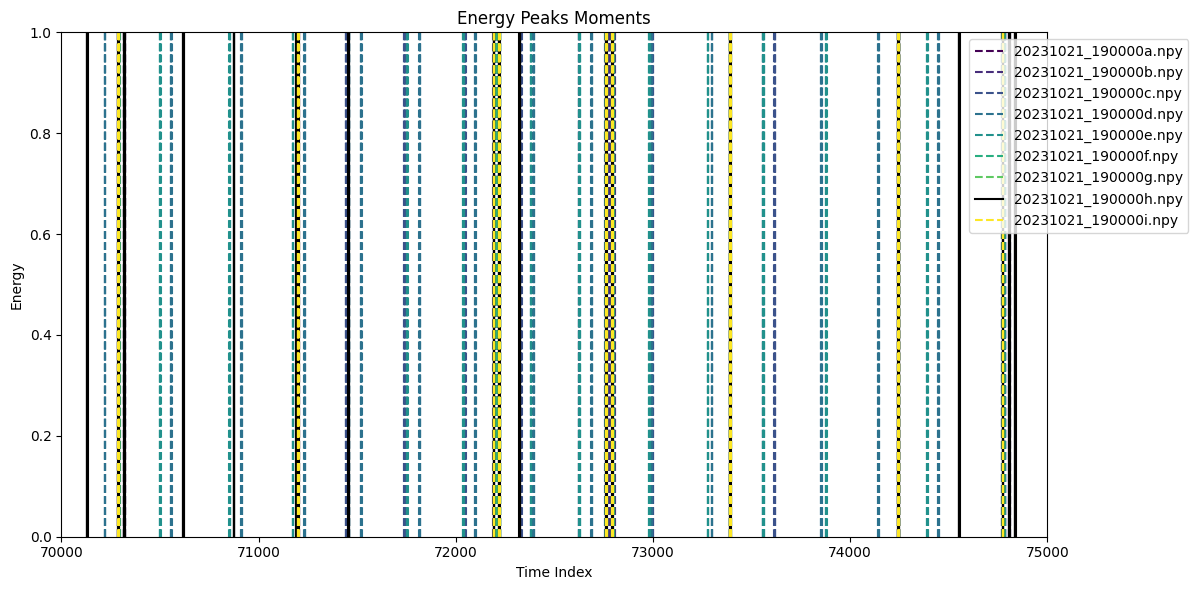

In [23]:
plot_energy_peaks_momments(
            energy_peaks_per_audio=new_peaks_momments, 
            pivot_file_name=pivot_file_name,
            xlim_left=70000, 
            xlim_right=75000
        )

APPLYING LAGS TO ORIGINAL AUDIO FILES

In [24]:
def apply_lags_to_saved_files(lags: dict, path_to_files_to_be_synchronized: str, data_destination_path: str = None) -> dict:
    """
    Apply time lags to .npy files and save the synchronized files to a specified directory.
    Parameters:
    lags (dict): A dictionary where keys are filenames and values are the lag values to be applied.
    path_to_files_to_be_synchronized (str): The path to the directory containing the .npy files to be synchronized.
    data_destination_path (str, optional): The path to the directory where the synchronized files will be saved. 
                                           If None, a default directory 'aligned/all' will be used.
    Returns:
    dict: A dictionary where keys are filenames and values are the processed numpy arrays with applied lags.
    """
   
    
    # List all .npy files in the specified directory
    files = [f for f in os.listdir(path_to_files_to_be_synchronized) if f.endswith('.npy')]

    # Define the directory to save the processed files
    if data_destination_path is not None:
        aligned_files = data_destination_path
    else:
        aligned_files = f"{os.path.dirname(os.path.abspath(__file__))}/aligned/all"

    # Create the directory if it doesn't exist
    os.makedirs(aligned_files, exist_ok=True)
    
    aligned_files_dict = {}

    # Process each file
    for file in files:
        # Load the .npy file
        file_data = np.load(os.path.join(path_to_files_to_be_synchronized, file))

        # Check if the file has an associated lag value
        if file in lags:
            lag = lags[file]
            # If the lag is positive, pad the beginning of the array and truncate the end
            if lag > 0:
                if file_data.ndim == 1:
                    file_data = np.pad(file_data, (lag, 0), 'constant')[:len(file_data)]
                elif file_data.ndim == 2:
                    file_data = np.pad(file_data, ((0, 0), (lag, 0)), 'constant')[:len(file_data), :]
            # If the lag is negative, pad the end of the array and truncate the beginning
            elif lag < 0:
                if file_data.ndim == 1:
                    file_data = np.pad(file_data, (0, -lag), 'constant')[-len(file_data):]
                elif file_data.ndim == 2:
                    file_data = np.pad(file_data, ((0, 0), (0, -lag)), 'constant')[-len(file_data):, :]
    
        # Save the processed data to the new directory
        np.save(os.path.join(aligned_files, file), file_data)
        
        aligned_files_dict[file] = file_data
    
    # Return the modified dictionary with adjusted peaks
    return aligned_files_dict

In [25]:
aligned_audios = apply_lags_to_saved_files(
        lags=lags,
        path_to_files_to_be_synchronized=data_source_path,
        data_destination_path=data_destination_path,
    )

ALIGNING PIPELINE

In [25]:
def align_audios_pipeline(data_source_path: str, pivot_file_name : str, preprocessed_data_path : str = None, data_destination_path : str = None, plots: bool = True, verbose : bool = True):
    """
    Aligns multiple audio files based on a pivot audio file by preprocessing, calculating temporal energies, identifying energy peaks, 
    and applying calculated lags to synchronize the audio files.
    
    Parameters:
    -----------
    data_source_path : str
        Path to the directory containing the source audio files.
    pivot_file_name : str
        Name of the pivot audio file used for alignment.
    preprocessed_data_path : str, optional
        Path to save the preprocessed audio data. If None, the preprocessed data is not saved.
    data_destination_path : str, optional
        Path to save the aligned audio files. If None, the aligned audio files are not saved.
    plots : bool, optional
        If True, plots of temporal energies, energy peaks, and their moments are generated. Default is True.
    verbose : bool, optional
        If True, prints detailed logs of the processing steps. Default is True.
    
    Returns:
    --------
    aligned_audios : list
        List of paths to the aligned audio files.
    """
    
    # Preprocess the audio data by applying frequency cuts
    if verbose:
        print("----------------------------PREPROCESSING AUDIO DATA-----------------------")
    saved_files_path = preprocess_data(
        data_source_path=data_source_path, 
        lowest_frec_cut=113, 
        highest_frec_cut=117, 
        data_destination_path=preprocessed_data_path
    )

    # Compute the temporal energy for each audio file
    if verbose:
        print("-------------------------CALCULATING TEMPORAL ENERGIES------------------------------")
    temporal_energy_per_audio = get_temporal_energies(
        freq_cut_source_path=saved_files_path
    )

    # Optionally plot the temporal energies
    if plots:
        if verbose:
            print("-------------------------PLOTTING TEMPORAL ENERGIES-------------------------------")
        plot_energies(temporal_energy_per_audio=temporal_energy_per_audio)

    # Calculating thresholds to eliminate noise
    energy_limits = plot_energies_histogram_and_get_bin_width(temporal_energies=temporal_energy_per_audio)

    # Filtering energies
    temporal_energy_per_audio = filter_temporal_energies(
    temporal_energy_per_audio=temporal_energy_per_audio, 
    energy_limits=energy_limits)

    # Identify energy peaks in the temporal energies
    if verbose:
        print("--------------------------------IDENTIFYING ENERGY PEAKS----------------------------")
    energy_peaks_per_audio = get_energy_peaks(
        temporal_energy_per_audio=temporal_energy_per_audio
    )

    # Optionally plot the energy peaks and their moments
    if plots:
        if verbose:
            print("------------------------------PLOTTING ENERGY PEAKS-----------------------------")
        plot_energy_peaks(
            energy_peaks_per_audio=energy_peaks_per_audio,
            temporal_energy_per_audio=temporal_energy_per_audio,
            # xlim_left=5000,
            # xlim_right=15000,
        )
        if verbose:
            print("-------------------PLOTTING ENERGY PEAKS ON A LOGATITHMIC SCALE-----------------------")
        plot_energy_peaks_log(
            energy_peaks_per_audio=energy_peaks_per_audio,
            temporal_energy_per_audio=temporal_energy_per_audio,
            # xlim_left=5000,
            # xlim_right=15000,
        )
        if verbose:
            print("-----------------------------PLOTTING ENERGY PEAKS MOMENTS-----------------------")
        plot_energy_peaks_momments(
            energy_peaks_per_audio=energy_peaks_per_audio,
            pivot_file_name=pivot_file_name,
            xlim_left=70000,
            xlim_right=75000,
        )

    # Calculate the lags required to align the audio files based on a pivot audio file
    if verbose:
        print("-------------------------------CALCULATING LAGS FOR ALIGNMENT-------------------------")
    lags, peaks_array_per_audio = get_lags(
        energy_peaks_per_audio=energy_peaks_per_audio,
        temporal_energy_per_audio=temporal_energy_per_audio,
        pivot_audio=pivot_file_name,
    )

    # Optionally apply the lags to the energy peaks and plot the aligned energy peaks
    if plots:
        if verbose:
            print("------------APPLYING LAGS TO ENERGY PEAKS AND PLOTTING ALIGNED PEAKS----------------")
        aligned_energy_peaks_per_audio = apply_lags_to_files(
            lags=lags, files_to_be_synchronized=peaks_array_per_audio
        )

        new_peaks_momments = {}
        for item in aligned_energy_peaks_per_audio:
            momments = []
            for i, peak in enumerate(aligned_energy_peaks_per_audio[item]):
                if peak != 0:
                    momments.append(i)
            new_peaks_momments[item] = momments
        plot_energy_peaks_momments(
            energy_peaks_per_audio=new_peaks_momments,
            pivot_file_name=pivot_file_name, 
            xlim_left=70000, 
            xlim_right=75000
        )

    # Apply the lags to the original audio files to produce aligned audio files
    if verbose:
        print("-----------------------APPLYING LAGS TO ORIGINAL AUDIO FILES----------------------")
    aligned_audios = apply_lags_to_saved_files(
        lags=lags,
        path_to_files_to_be_synchronized=data_source_path,
        data_destination_path=data_destination_path,
    )
    if verbose:
        print("--------------------------AUDIO ALIGNMENT COMPLETE.------------------------------------")
    return aligned_audios

In [26]:
data_source_path = '../data/not_aligned/all'
pivot_file_name = '20231021_190000h.npy'
preprocessed_data_path = '../data/not_aligned/freq_cut'
data_destination_path = '../data/aligned/all'


aligned_audios = align_audios_pipeline(
    data_source_path=data_source_path, 
    pivot_file_name=pivot_file_name, 
    preprocessed_data_path=preprocessed_data_path, 
    data_destination_path=data_destination_path,  
    plots=True, 
    verbose=True)